In [1]:
import numpy as np
import collections
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate, integrate, optimize
import plotly as py
import plotly.graph_objs as go
from simanneal import Annealer

py.offline.init_notebook_mode(connected = True)

In [2]:
# Read coordinates of characters from txt

char_pos_dict = {}

with open("keyboard_data.txt", 'r') as f:
    for line in f:
        pos_x, pos_y, char = line.split()
        char_pos_dict[char] = np.array([float(pos_x), float(pos_y)])
        
    print(char_pos_dict)

{'a': array([170.425, 387.075]), 'b': array([1151.92307692,  670.84615385]), 'c': array([761.85714286, 633.28571429]), 'd': array([572.37037037, 409.55555556]), 'e': array([483.875, 159.   ]), 'f': array([767.66666667, 420.79166667]), 'g': array([946.76923077, 441.84615385]), 'h': array([1164.66666667,  440.22222222]), 'i': array([1440.48148148,  176.46296296]), 'j': array([1358.83333333,  432.27777778]), 'k': array([1556.94736842,  430.05263158]), 'l': array([1758.77049444,  400.16208222]), 'm': array([1537.86956522,  642.43478261]), 'n': array([1339.  ,  644.04]), 'o': array([1629.2       ,  187.66666667]), 'p': array([1807.52,  199.24]), 'q': array([ 95.36363636, 159.27272727]), 'r': array([671.625, 181.875]), 's': array([376.66666667, 386.16666667]), 't': array([850.21153846, 191.86489365]), 'u': array([1241.29166667,  184.33333333]), 'v': array([936.18181818, 652.59090909]), 'w': array([275.26470588, 170.38235294]), 'x': array([578.55555556, 635.22222222]), 'y': array([1051.934782

Characters to sections: defaultdict(<class 'int'>, {'a': 0, 'b': 1, 'c': 0, 'd': 0, 'e': 0, 'f': 0, 'g': 2, 'h': 1, 'i': 1, 'j': 1, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 0, 'r': 0, 's': 0, 't': 0, 'u': 1, 'v': 2, 'w': 0, 'x': 0, 'y': 1, 'z': 0})
Initial thumb positions: [[ 497.60677357  362.75764994]
 [1419.86986965  383.05611632]]


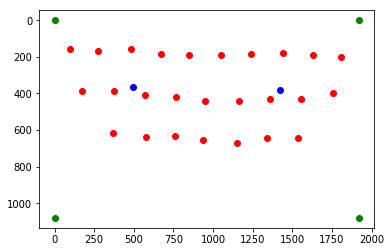

In [3]:
# Divide into left, right and middle sections of keyboard

left_keys = set(list("qwertasdfzxc"))
right_keys = set(list("yuiophjklbnm"))
middle_keys = set(list("gv"))

keyboard_sections = [left_keys, right_keys, middle_keys]

char_section_dict = collections.defaultdict(int)
for char_ascii in range(26):
    char = chr(ord("a") + char_ascii)
    for ind, section in enumerate(keyboard_sections):
        if char in section:
            char_section_dict[char] = ind
            break
print("Characters to sections: {}".format(char_section_dict))

# Initialize left thumb and right thumb positions
left_mean = np.mean(np.array([char_pos_dict[char] for char in left_keys]), axis = 0)
right_mean =  np.mean(np.array([char_pos_dict[char] for char in right_keys]), axis = 0)

thumbs_pos = np.array([left_mean, right_mean])
print("Initial thumb positions: {}". format(thumbs_pos))

for char in char_pos_dict:
    plt.plot(char_pos_dict[char][0], char_pos_dict[char][1], "ro")

for pos_x, pos_y in thumbs_pos:
    plt.plot(pos_x, pos_y, "bo")

plt.plot([0,0,1920,1920],[0,1080,0,1080], "go")    
plt.gca().invert_yaxis()

In [4]:
# Read passages from txt and remove non-alphabetical characters
cleaned_passage = []
with open("pride_and_prejudice.txt", 'r') as f:
    for line in f:
        for char in line:
            if char.isalpha():
                cleaned_passage.append(char.lower())

In [5]:
# Assume first order relations between buttons and type with only one hand
first_order_count = np.array([[0 for i in range(26)] for j in range(26)])

for ind in range(len(cleaned_passage) - 1):
    first_order_count[ord(cleaned_passage[ind]) - ord('a')][ord(cleaned_passage[ind+1]) - ord('a')] += 1

total_dist = 0

for i in range(26):
    for j in range(26):
        pos1, pos2 = char_pos_dict[chr(i + ord('a'))], char_pos_dict[chr(j + ord('a'))]
        total_dist += np.linalg.norm(pos1 - pos2) * first_order_count[i][j]
        
print("Total distance when typing with one hand: {}".format(total_dist))
    

Total distance when typing with one hand: 9006853.584351972


Calculated curve_length: 1047.7239022334845
Numerical error: 1.490193787793696e-05
Scaled length:(959.9999999999999, 1.3654227396675407e-05)


Text(0.5, 1.0, 'Initial keyboard shape after scaling by curve length')

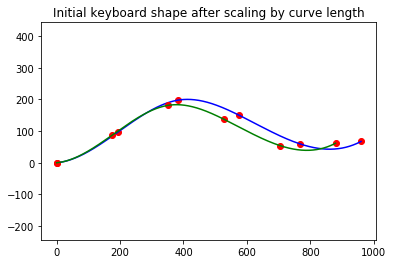

In [6]:
# Decide number of control points to define the curve (probably 1D curve first)
dof = 5
max_height = 200
# Since the keyboard is symmetric, we only need to define half of the keyboard.
inpl_h, inpl_w = 1080*3/4, 1920/2
# Use B-spline to fit the points (to get a smooth surface)
inpl_x = np.array(list(range(0, dof + 1))) / dof * inpl_w
inpl_y = np.random.rand(dof + 1) * max_height
inpl_y[0] = 0

# Interpolate with B-spline
tck = interpolate.splrep(inpl_x, inpl_y, s = 0)
xnew = np.linspace(0, inpl_w, int(inpl_w) * 3)
ynew = interpolate.splev(xnew, tck, der = 0)

plt.plot(inpl_x, inpl_y, 'ro', xnew, ynew, 'b') 
plt.axis('equal')
plt.title("Initial keyboard shape without scaling")
# Find length of spline by numerical integration
# Normalize movement in x direction by curve length to ensure the final lengh
length_integral = lambda x, func: np.sqrt(1 + interpolate.splev(x, func, der = 1) ** 2)
curve_integral = lambda x: length_integral(x, tck)
find_curve_length = lambda x: scipy.integrate.quad(curve_integral,0, x)
total_curve_length, error = find_curve_length(inpl_w)
print("Calculated curve_length: {}".format(total_curve_length))
print("Numerical error: {}".format(error))

scale_factor = inpl_w/total_curve_length
scaled_spline = interpolate.splrep(inpl_x * scale_factor, inpl_y * scale_factor, s = 0)
scaled_xnew = xnew * scale_factor
scaled_ynew = interpolate.splev(scaled_xnew, scaled_spline, der = 0)
scaled_curve_integral  = lambda x: length_integral(x, scaled_spline)
scaled_curve_length = lambda x: scipy.integrate.quad(scaled_curve_integral, 0, x)
print("Scaled length:{}".format(scaled_curve_length(inpl_w * scale_factor)))
plt.plot(inpl_x * scale_factor, inpl_y * scale_factor, 'ro', scaled_xnew, scaled_ynew, 'g-')
plt.axis('equal')
plt.title("Initial keyboard shape after scaling by curve length")

# Option 1. constraint the total length to be 1920 or Option 2 only constrain the coordinates of points
# project points back onto the curve
# for option 1. project onto curve using length
# optimize the height of the points to reduce the movement of the thumbs

In [7]:
def plotMeshShape(x,spline, plot_points = False, points = None):
    y = np.linspace(0, inpl_h,3)
    X, Y = np.meshgrid(x,y)
    Z = interpolate.splev(X, spline, der = 0)
    data = [go.Mesh3d(x = X.flatten(), y= Y.flatten(), z= Z.flatten())]
    layout = go.Layout(
             scene=dict(
                 aspectmode='data'))
    fig = go.Figure(data = data, layout = layout)

    if plot_points:
        extra_points = go.Scatter3d(x = points[:,0], 
                                    y = points[:,1], 
                                    z = points[:,2], 
                                    mode = 'markers',
                                    marker=dict(
                                        size=12,
                                        #color=z,                # set color to an array/list of desired values
                                        #colorscale='Viridis',   # choose a colorscale
                                        opacity=0.8
                                    ))
        fig = go.Figure(data + [extra_points], layout = layout)
    
    py.offline.iplot(fig)
    
plotMeshShape(scaled_xnew ,scaled_spline, True, np.array([[1200,1,2]]))

In [8]:
# Assume the new keyboard is formed by folding the keyboard onto the curved surface

new_locations = []
curved_char_pos_dict = {}
for key in left_keys:
    flat_x, flat_y = char_pos_dict[key]
    pos_x_on_curved_keyboard = optimize.brentq(lambda x: scaled_curve_length(x)[0] - flat_x, 0, inpl_w)
    
    new_location = np.array([pos_x_on_curved_keyboard, flat_y, interpolate.splev(pos_x_on_curved_keyboard, scaled_spline, der = 0) ])
    new_locations.append(new_location)
    print("Key: {}\tCurved x: {}".format(key, pos_x_on_curved_keyboard))
    curved_char_pos_dict[key] = new_location
    
plotMeshShape(scaled_xnew ,scaled_spline, True, np.array(new_locations))
    
    

Key: a	Curved x: 152.68417201396403
Key: q	Curved x: 89.40011692259333
Key: t	Curved x: 773.5218970995339
Key: x	Curved x: 522.8115154217462
Key: r	Curved x: 605.6328412304238
Key: e	Curved x: 435.1177066287155
Key: c	Curved x: 687.8085545285537
Key: d	Curved x: 517.2554131731098
Key: w	Curved x: 238.80738228495824
Key: z	Curved x: 320.53626984247666
Key: f	Curved x: 693.266062133704
Key: s	Curved x: 329.3693165890927


In [9]:
# Only consider letters typed by left hand

def left_thumb_movement(curved_pos_dict):
    prev_char = None
    dist = 0
    for char in cleaned_passage:
        if char in left_keys:
            if prev_char == None:
                prev_char = char

            else:
                pos1, pos2 = curved_pos_dict[prev_char], curved_char_pos_dict[char]
                dist += np.linalg.norm(pos1 - pos2)
    return dist

left_thumb_movement(curved_char_pos_dict)
            
            

2585704.27007243

In [80]:
# Define optimization problem to be solved

class OptimizedKeyboardProblem(Annealer):
    
    def move(self):
        movement = np.random.randint(-1,1,len(self.state))
        movement[0] = 0
        self.state = self.state + movement
        #print("State: {}".format(self.state))
        
    def energy(self):
        
        spline = self.formScaledSplineFromControlPoints(self.state)
        curved_pos_char_dict = self.flatToCurved(spline)
        total_dist = self.calculateMovement(curved_pos_char_dict)
        
        #print("Spline: {}".format(spline))
        #print("New loc: {}".format(curved_pos_char_dict["d"]))
        #print("Distance: {}".format(total_dist))
        return total_dist
    
    def update(self, step, T, E, acceptance, improvement):
        print("Temperature: {}\tError: {}\tAcceptance:{}".format(T,E,acceptance))
        
    
    def findFunctionCurveLength(self,x, func):
        curve_integral = lambda x: np.sqrt(1 + interpolate.splev(x, func, der = 1) ** 2)
        find_curve_length = lambda x: scipy.integrate.quad(curve_integral,0, x)
        return find_curve_length(x)
    
    def formScaledSplineFromControlPoints(self,cp):
        # Interpolate with B-spline
        #print("CP: {}".format(cp))
        tck = interpolate.splrep(inpl_x, cp, s = 0)
        total_curve_length, error = self.findFunctionCurveLength(inpl_w, tck)

        scale_factor = inpl_w/total_curve_length
        scaled_spline = interpolate.splrep(inpl_x * scale_factor, inpl_y * scale_factor, s = 0)
        
        return scaled_spline
        
    def flatToCurved(self, spline):
        curved_char_pos_dict = {}
        for key in left_keys:
            flat_x, flat_y = char_pos_dict[key]
            pos_x_on_curved_keyboard = optimize.brentq(lambda x: self.findFunctionCurveLength(x, spline)[0] - flat_x, 0, inpl_w)

            new_location = np.array([pos_x_on_curved_keyboard, flat_y, interpolate.splev(pos_x_on_curved_keyboard, spline, der = 0) ])
            curved_char_pos_dict[key] = new_location
        
        return curved_char_pos_dict
            
    def calculateMovement(self, curved_pos_char_dict):
        prev_char = None
        dist = 0
        for char in cleaned_passage:
            if char in left_keys:
                if prev_char == None:
                    prev_char = char

                else:
                    pos1, pos2 = curved_pos_char_dict[prev_char], curved_char_pos_dict[char]
                    dist += np.linalg.norm(pos1 - pos2)
        return dist
        
        

In [37]:
initial_state = inpl_y
optimizer = OptimizedKeyboardProblem(state)
optimizer.updates = 1000
optimizer.steps = 10000
optimizer.Tmax = 7000
optimizer.Tmin = 10
optimizer.copy_strategy = "slice"

In [38]:
state, dist = optimizer.anneal()

Temperature: 7000	Error: 2576658.6493678237	Acceptance:None
Temperature: 6954.29231846979	Error: 2577198.4627898405	Acceptance:1.0
Temperature: 6908.883092961133	Error: 2576708.2337062233	Acceptance:1.0
Temperature: 6863.770374655059	Error: 2575955.5006105285	Acceptance:1.0
Temperature: 6818.952227457741	Error: 2575857.395693016	Acceptance:1.0
Temperature: 6774.426727917405	Error: 2576866.5601438247	Acceptance:1.0
Temperature: 6730.191965141778	Error: 2577380.492323576	Acceptance:1.0
Temperature: 6686.246040716081	Error: 2578140.3693403625	Acceptance:1.0
Temperature: 6642.587068621556	Error: 2577247.734749091	Acceptance:1.0
Temperature: 6599.213175154521	Error: 2577481.7098833127	Acceptance:1.0
Temperature: 6556.12249884596	Error: 2578772.3959962167	Acceptance:1.0
Temperature: 6513.313190381632	Error: 2580663.125367707	Acceptance:1.0
Temperature: 6470.783412522706	Error: 2582971.9482835555	Acceptance:1.0
Temperature: 6428.531340026912	Error: 2583219.1274673366	Acceptance:1.0
Temperatur

Temperature: 3295.4275295047437	Error: 2495977.633629047	Acceptance:1.0
Temperature: 3273.909479215531	Error: 2494621.3238131846	Acceptance:1.0
Temperature: 3252.531934667714	Error: 2493027.2105083438	Acceptance:1.0
Temperature: 3231.2939784053387	Error: 2491517.9458128475	Acceptance:1.0
Temperature: 3210.1946989631333	Error: 2489030.578086074	Acceptance:1.0
Temperature: 3189.233190827394	Error: 2487118.4784799195	Acceptance:1.0
Temperature: 3168.408554397121	Error: 2485520.810673949	Acceptance:1.0
Temperature: 3147.71989594541	Error: 2484550.159424727	Acceptance:1.0
Temperature: 3127.166327581099	Error: 2482869.3538426924	Acceptance:1.0
Temperature: 3106.74696721066	Error: 2481917.878582052	Acceptance:0.8
Temperature: 3086.460938500344	Error: 2480375.1185302646	Acceptance:1.0
Temperature: 3066.3073708385714	Error: 2478911.7320919293	Acceptance:1.0
Temperature: 3046.2853992985683	Error: 2477604.086744056	Acceptance:1.0
Temperature: 3026.3941646012445	Error: 2476920.5840204246	Acceptanc

Temperature: 1561.602835327365	Error: 2590921.387514903	Acceptance:0.9
Temperature: 1551.4060860311054	Error: 2591705.861632175	Acceptance:0.8
Temperature: 1541.2759181304857	Error: 2592755.0955811017	Acceptance:0.7
Temperature: 1531.2118968710442	Error: 2592004.889287769	Acceptance:0.7
Temperature: 1521.2135903371227	Error: 2591150.9056009315	Acceptance:0.8
Temperature: 1511.2805694333288	Error: 2591053.2685183682	Acceptance:0.8
Temperature: 1501.4124078661214	Error: 2594201.9169512647	Acceptance:0.9
Temperature: 1491.6086821255142	Error: 2595577.308056485	Acceptance:0.9
Temperature: 1481.8689714669015	Error: 2595696.1315871705	Acceptance:0.6
Temperature: 1472.1928578930003	Error: 2596867.4882941935	Acceptance:1.0
Temperature: 1462.5799261359114	Error: 2599259.280565306	Acceptance:1.0
Temperature: 1453.0297636392975	Error: 2600672.169827022	Acceptance:0.6
Temperature: 1443.5419605406773	Error: 2599702.316509193	Acceptance:0.8
Temperature: 1434.116109653836	Error: 2600862.3481487175	Ac

Temperature: 735.1641390986372	Error: 2746981.37888927	Acceptance:0.7
Temperature: 730.3637607640158	Error: 2749472.8974853833	Acceptance:0.6
Temperature: 725.5947273099861	Error: 2750502.354173817	Acceptance:0.5
Temperature: 720.8568340648596	Error: 2754073.374438369	Acceptance:0.9
Temperature: 716.1498776933864	Error: 2755251.4018349745	Acceptance:0.7
Temperature: 711.4736561880281	Error: 2757814.5299816527	Acceptance:0.8
Temperature: 706.8279688602889	Error: 2758816.020093593	Acceptance:0.4
Temperature: 702.2126163321012	Error: 2760663.897949058	Acceptance:0.5
Temperature: 697.6274005272725	Error: 2762514.6917218072	Acceptance:0.8
Temperature: 693.0721246629798	Error: 2763849.715634517	Acceptance:0.7
Temperature: 688.5465932413281	Error: 2765189.1180015346	Acceptance:0.7
Temperature: 684.0506120409586	Error: 2765533.659267884	Acceptance:0.5
Temperature: 679.5839881087142	Error: 2767170.3239497053	Acceptance:0.5
Temperature: 675.1465297513565	Error: 2768005.7168154186	Acceptance:0.4


Temperature: 346.097163241472	Error: 2906651.6407919936	Acceptance:0.5
Temperature: 343.8372633963362	Error: 2906735.7283881116	Acceptance:0.1
Temperature: 341.5921199486878	Error: 2907349.5899630594	Acceptance:0.5
Temperature: 339.36163654413883	Error: 2908743.293138548	Acceptance:0.4
Temperature: 337.1457174574631	Error: 2909307.271192597	Acceptance:0.2
Temperature: 334.9442675884888	Error: 2910310.435270546	Acceptance:0.4
Temperature: 332.7571924580168	Error: 2911779.1491406634	Acceptance:0.6
Temperature: 330.5843982037656	Error: 2911877.443068357	Acceptance:0.1
Temperature: 328.4257915763436	Error: 2913800.150447275	Acceptance:0.6
Temperature: 326.28127993524663	Error: 2914245.309855638	Acceptance:0.3
Temperature: 324.15077124488255	Error: 2915003.415527451	Acceptance:0.3
Temperature: 322.0341740706207	Error: 2915284.9874339695	Acceptance:0.2
Temperature: 319.93139757486864	Error: 2916056.6599978264	Acceptance:0.5
Temperature: 317.8423515131733	Error: 2918086.0065651406	Acceptance:

Temperature: 164.00491486391908	Error: 2979398.2266849056	Acceptance:0.1
Temperature: 162.93401708992056	Error: 2980820.422505424	Acceptance:0.5
Temperature: 161.87011192369428	Error: 2980830.109962224	Acceptance:0.1
Temperature: 160.81315370582752	Error: 2980830.109962224	Acceptance:0.2
Temperature: 159.76309707504828	Error: 2981762.950931515	Acceptance:0.5
Temperature: 158.71989696627872	Error: 2981851.774226215	Acceptance:0.1
Temperature: 157.68350860870137	Error: 2982431.607522997	Acceptance:0.3
Temperature: 156.65388752383663	Error: 2982736.882692119	Acceptance:0.4
Temperature: 155.6309895236355	Error: 2983428.2083096546	Acceptance:0.2
Temperature: 154.61477070858146	Error: 2983505.2123052264	Acceptance:0.1
Temperature: 153.60518746580797	Error: 2984212.6058957665	Acceptance:0.2
Temperature: 152.60219646722584	Error: 2984377.5661873054	Acceptance:0.1
Temperature: 151.60575466766377	Error: 2985851.814328277	Acceptance:0.4
Temperature: 150.61581930302128	Error: 2985851.814328277	Acc

Temperature: 77.71693893010865	Error: 3000635.0948386258	Acceptance:0.0
Temperature: 77.20947305952005	Error: 3000635.0948386258	Acceptance:0.1
Temperature: 76.7053207729887	Error: 3000635.0948386258	Acceptance:0.1
Temperature: 76.20446043390807	Error: 3000635.0948386258	Acceptance:0.0
Temperature: 75.70687054695165	Error: 3000635.0948386258	Acceptance:0.0
Temperature: 75.21252975715042	Error: 3000635.0948386258	Acceptance:0.0
Temperature: 74.72141684897596	Error: 3000635.0948386258	Acceptance:0.0
Temperature: 74.23351074543038	Error: 3000635.0948386258	Acceptance:0.0
Temperature: 73.74879050714158	Error: 3000635.0948386258	Acceptance:0.0
Temperature: 73.26723533146463	Error: 3000635.0948386258	Acceptance:0.0
Temperature: 72.78882455158904	Error: 3000797.371981335	Acceptance:0.1
Temperature: 72.3135376356515	Error: 3000797.371981335	Acceptance:0.0
Temperature: 71.84135418585531	Error: 3000874.7022680896	Acceptance:0.2
Temperature: 71.37225393759451	Error: 3000874.7022680896	Acceptance:

Temperature: 36.58722000844558	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 36.348317579842465	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 36.110975104971274	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 35.87518239785082	Error: 3003210.6444708128	Acceptance:0.1
Temperature: 35.6409293390109	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 35.4082058750583	Error: 3003210.6444708128	Acceptance:0.2
Temperature: 35.177002018245005	Error: 3003210.6444708128	Acceptance:0.1
Temperature: 34.94730784603964	Error: 3003210.6444708128	Acceptance:0.1
Temperature: 34.71911350070179	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 34.492409188858744	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 34.26718518108531	Error: 3003210.6444708128	Acceptance:0.1
Temperature: 34.043431811486194	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 33.821139477281214	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 33.60029863839316	Error: 3003210.6444708128	Acc

Temperature: 17.45152297724032	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 17.33757031231734	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 17.22436172055405	Error: 3003210.6444708128	Acceptance:0.1
Temperature: 17.111892343399163	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 17.000157354026115	Error: 3003210.6444708128	Acceptance:0.1
Temperature: 16.88915195712593	Error: 3003210.6444708128	Acceptance:0.1
Temperature: 16.77887138870141	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 16.669310915862678	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 16.560465836624076	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 16.452331479702313	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 16.344903204316058	Error: 3003210.6444708128	Acceptance:0.1
Temperature: 16.238176399986788	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 16.132146486340794	Error: 3003210.6444708128	Acceptance:0.0
Temperature: 16.02680891291274	Error: 3003210.6444708128

In [42]:
state

array([   0.        , -694.07064889, -538.20899717, -571.33468477,
       -655.6142415 , -651.69891907])

0.5983753236168725
2472063.9353212793


Text(0.5, 1.0, 'Initial keyboard shape after scaling by curve length')

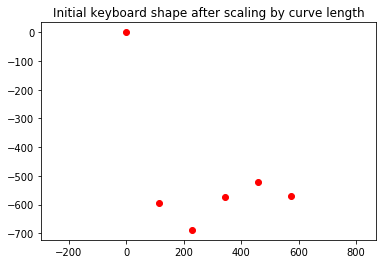

In [79]:
tck = interpolate.splrep(inpl_x, state, s = 0)
spline2 = optimizer.formScaledSplineFromControlPoints(state)
scale_factor = inpl_w / optimizer.findFunctionCurveLength(inpl_w, tck)[0]
print(scale_factor)
curved_pos_char_dict = optimizer.flatToCurved(spline)
total_dist = optimizer.calculateMovement(curved_pos_char_dict)
print(total_dist)
xnew = np.linspace(0, inpl_w * scale_factor, int(inpl_w))
ynew = interpolate.splev(xnew, spline2, der = 0)

plt.plot(inpl_x * scale_factor, interpolate.splev(inpl_x * scale_factor, tck, der = 0),'ro')
plt.axis('equal')
plt.title("Initial keyboard shape after scaling by curve length")

In [74]:
inpl_x

array([  0., 192., 384., 576., 768., 960.])

In [72]:
ynew

array([-1.59739213e-15,  5.88593042e-02,  1.21441047e-01,  1.87726225e-01,
        2.57695833e-01,  3.31330868e-01,  4.08612327e-01,  4.89521204e-01,
        5.74038497e-01,  6.62145201e-01,  7.53822313e-01,  8.49050828e-01,
        9.47811743e-01,  1.05008605e+00,  1.15585476e+00,  1.26509885e+00,
        1.37779932e+00,  1.49393717e+00,  1.61349340e+00,  1.73644901e+00,
        1.86278498e+00,  1.99248231e+00,  2.12552201e+00,  2.26188506e+00,
        2.40155247e+00,  2.54450522e+00,  2.69072432e+00,  2.84019076e+00,
        2.99288554e+00,  3.14878965e+00,  3.30788409e+00,  3.47014986e+00,
        3.63556794e+00,  3.80411935e+00,  3.97578507e+00,  4.15054610e+00,
        4.32838343e+00,  4.50927807e+00,  4.69321100e+00,  4.88016323e+00,
        5.07011575e+00,  5.26304956e+00,  5.45894564e+00,  5.65778501e+00,
        5.85954865e+00,  6.06421756e+00,  6.27177274e+00,  6.48219519e+00,
        6.69546589e+00,  6.91156584e+00,  7.13047605e+00,  7.35217751e+00,
        7.57665120e+00,  